In [1]:
%matplotlib inline

# Image filtering

## Image filtering theory

Filtering is one of the most basic and common image operations in image processing. You can filter an image to remove noise or to enhance features; the filtered image could be the desired result or just a preprocessing step. Regardless, filtering is an important topic to understand.

### Local filtering

Let's get started by setting the colormap to grayscale and turning off pixel interpolation, as discussed in the previous section.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

The "local" in local filtering simply means that a pixel is adjusted by values in some surrounding neighborhood. These surrounding elements are identified or weighted based on a "footprint", "structuring element", or "kernel".

Let's go to back to basics and look at a 1D step-signal

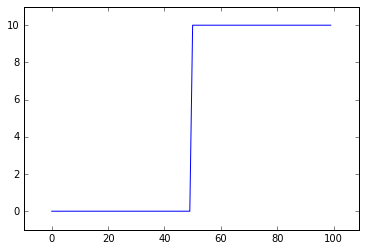

In [3]:
step_signal = np.zeros(100)
step_signal[50:] = 10
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(0.1)

Now add some (very) artificial noise to this signal:

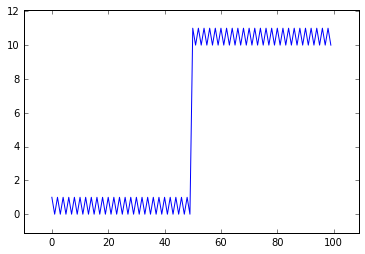

In [4]:
noisy_signal = np.copy(step_signal)
noisy_signal[::2] += 1
fig, ax = plt.subplots()
ax.plot(noisy_signal)
ax.margins(0.1)

The simplest way to recover something that looks like the original image is to take the average between neighboring pixels:

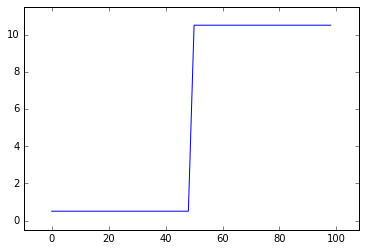

In [5]:
# Take the mean of neighboring pixels
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0
fig, ax = plt.subplots()
ax.plot(smooth_signal)
ax.margins(0.1)

This same concept, nearest-neighbor averages, can be expressed as a convolution with an averaging kernel:

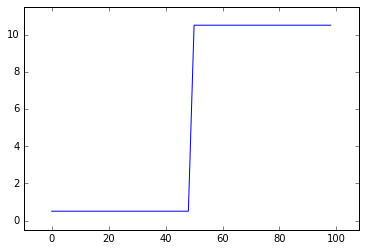

In [6]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/2 and summed
mean_kernel = np.array([1, 1]) / 2.0
smooth_signal = np.convolve(noisy_signal, mean_kernel, mode='valid')
fig, ax = plt.subplots()
ax.plot(smooth_signal)
ax.margins(0.1)

### Local filtering of images

Now let's apply this to a real image. Let's start with an incredibly simple image:

In [7]:
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

This gives the values below:

In [8]:
print(bright_square)

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


and looks like a white square centered on a black square:

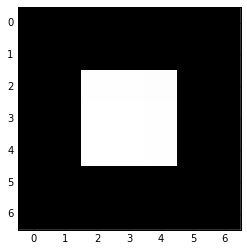

In [9]:
fig, ax = plt.subplots()
ax.imshow(bright_square);

### The mean filter

For our first example of a filter, consider the following filtering array, which we'll call a "mean kernel". For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [10]:
mean_kernel = 1.0/9.0 * np.ones((3, 3))

print(mean_kernel)

[[ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]]


Now, let's take our mean kernel and apply it to every pixel of the image.

Applying a (linear) filter essentially means:
* Center a kernel on a pixel
* Multiply the pixels *under* that kernel by the values *in* the kernel
* Sum all the those results
* Replace the center pixel with the summed result

This process is known as convolution.

Let's take a look at the numerical result:

In [11]:
from scipy.ndimage import convolve

%precision 2
print(bright_square)
print(convolve(bright_square, mean_kernel))

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
[[ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.11  0.22  0.33  0.22  0.11  0.  ]
 [ 0.    0.22  0.44  0.67  0.44  0.22  0.  ]
 [ 0.    0.33  0.67  1.    0.67  0.33  0.  ]
 [ 0.    0.22  0.44  0.67  0.44  0.22  0.  ]
 [ 0.    0.11  0.22  0.33  0.22  0.11  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]


The meaning of "mean kernel" should be clear now: Each pixel was replaced with the mean value within the 3x3 neighborhood of that pixel. When the kernel was over `n` bright pixels, the pixel in the kernel's center was changed to n/9 (= n * 0.111). When no bright pixels were under the kernel, the result was 0.

This filter is a simple smoothing filter and produces two important results:
1. The intensity of the bright pixel decreased.
2. The intensity of the region near the bright pixel increased.

Let's see a convolution in action:

In [12]:
#--------------------------------------------------------------------------
#  Convolution Demo
#--------------------------------------------------------------------------
from skimage import color
from scipy import ndimage as ndi

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image)

    image_cache = []

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][1]
            filtered = filtered.copy()

            (i, j), mask, subimage = next(iter_kernel_and_subimage)
            filter_overlay = color.label2rgb(mask, image, bg_label=0,
                                             colors=('yellow', 'red'))
            filtered[i, j] = np.sum(mean_factor * subimage)
            image_cache.append((filter_overlay, filtered))

        nimages = len(image_cache[i_step])
        fig, axes = plt.subplots(1, nimages, figsize=(10, 5))
        for ax, imc in zip(axes, image_cache[i_step]):
            ax.imshow(imc, vmax=vmax)
        plt.show()
    return mean_filter_step


def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact
    mean_filter_step = mean_filter_demo(image)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(mean_filter_step, i_step=step_slider)


def iter_kernel(image, size=1):
    """ Yield position, kernel mask, and image for each pixel in the image.

    The kernel mask has a 2 at the center pixel and 1 around it. The actual
    width of the kernel is 2*size + 1.
    """
    width = 2*size + 1
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16')
        mask[i, j] = 1
        mask = ndi.grey_dilation(mask, size=width)
        mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)]
        yield (i, j), mask, subimage


def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]


def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = []
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)))
    return slices



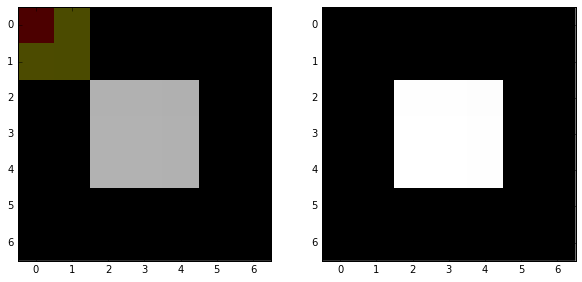

In [14]:
mean_filter_interactive_demo(bright_square)

Slight aside:

In [15]:
print(np.sum(mean_kernel))

1.0


Note that all the values of the kernel sum to 1. Why might that be important? Sure, a definition of a mean requires this property, but why might this be a favorable property for many image filters?

### Downsampled image

Let's consider a real image now. It'll be easier to see some of the filtering we're doing if we downsample the image a bit. We can slice into the image using the "step" argument to sub-sample it:

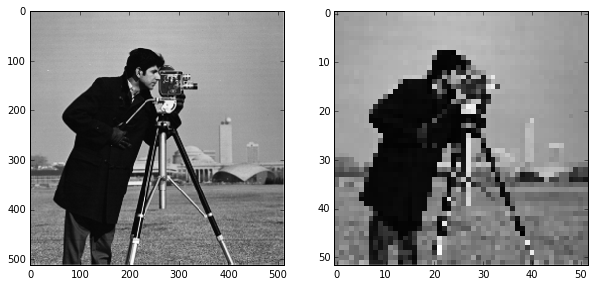

In [16]:
from skimage import data

image = data.camera()
pixelated = image[::10, ::10]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image)
ax1.imshow(pixelated)

Here we use a step of 10, giving us every tenth column and every tenth row of the original image. You can see the highly pixelated result on the right.

We are actually going to be using the pattern of plotting multiple images side by side quite often, so we are going to make the following helper function:

In [17]:
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)


### Mean filter on a real image

Now we can apply the filter to this downsampled image:

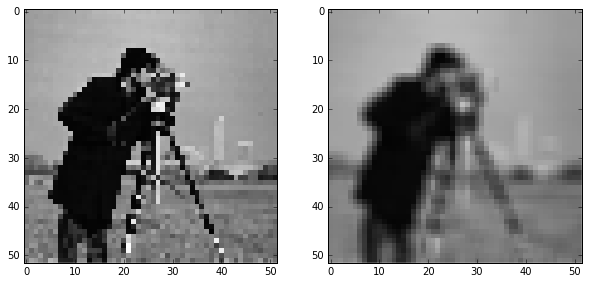

In [19]:
filtered = convolve(pixelated, mean_kernel)
imshow_all(pixelated, filtered)

Comparing the filtered image to the pixelated image, we can see that this filtered result is smoother: Sharp edges (which are just borders between dark and bright pixels) are smoothed because dark pixels reduce the intensity of neighboring pixels and bright pixels do the opposite.

## Essential filters

If you read through the last section, you're already familiar with the essential concepts of image filtering. But, of course, you don't have to create custom filter kernels for all of your filtering needs.


### Gaussian filter

The classic image filter is the Gaussian filter. This is similar to the mean filter, in that it tends to smooth images. The Gaussian filter, however, doesn't weight all values in the neighborhood equally. Instead, pixels closer to the center are weighted more than those farther away.

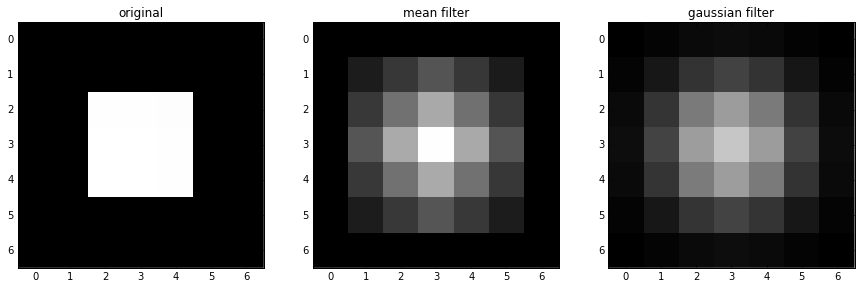

In [20]:
# Rename module so we don't shadow the builtin function
from skimage import filters

smooth_mean = convolve(bright_square, mean_kernel)
sigma = 1
smooth = filters.gaussian(bright_square, sigma)
imshow_all(bright_square, smooth_mean, smooth,
           titles=['original', 'mean filter', 'gaussian filter'])

For the Gaussian filter, `sigma`, the standard deviation, defines the size of the neighborhood.

For a real image, we get the following:

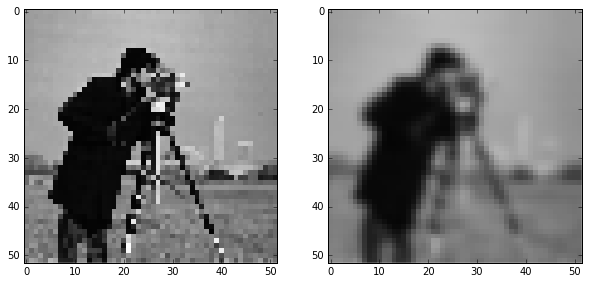

In [21]:
from skimage import img_as_float
# The Gaussian filter returns a float image, regardless of input.
# Cast to float so the images have comparable intensity ranges.
pixelated_float = img_as_float(pixelated)
smooth = filters.gaussian(pixelated_float, 1)
imshow_all(pixelated_float, smooth)

This doesn't look drastically different than the mean filter, but the Gaussian filter is typically preferred because of the distance-dependent weighting. For a more detailed image and a larger filter, you can see artifacts in the mean filter since it doesn't take distance into account:

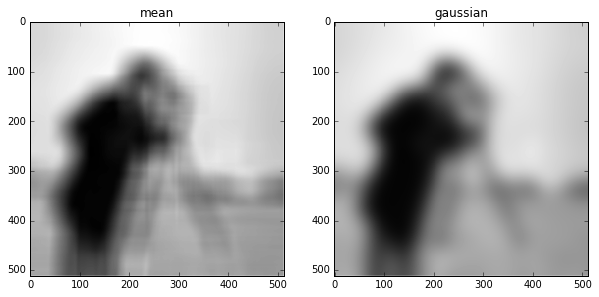

In [23]:
size = 20
structuring_element = np.ones((3*size, 3*size))
smooth_mean = filters.rank.mean(image, structuring_element)
smooth_gaussian = filters.gaussian(image, size)
titles = ['mean', 'gaussian']
imshow_all(smooth_mean, smooth_gaussian, titles=titles)

The size of the structuring element used for the mean filter and the size (standard deviation) of the Gaussian filter are tweaked to produce an approximately equal amount of smoothing in the two results.

### Basic edge filtering

For images, edges are boundaries between light and dark values. The detection of edges can be useful on its own, or it can be used as preliminary step in other algorithms (which we'll see later).

#### A 1D difference filter

Let's first consider a 1D edge, which is just the boundary in a step function:

In [24]:
step = np.zeros(40)
step[20:] = 1

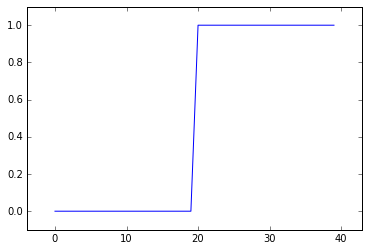

In [25]:
fig, ax = plt.subplots()
ax.plot(step)
ax.margins(0.1) 

To "detect" the edge, we can just take a difference of neighboring values. Here, we'll use convolution or cross-correlation to do just that:

In [26]:
edge = np.convolve(step, np.array([1, -1]), mode='valid')

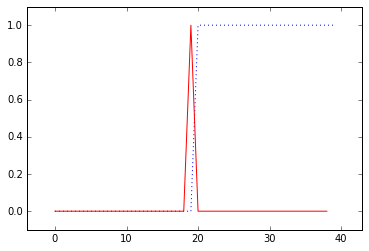

In [27]:
fig, ax = plt.subplots()
ax.plot(step, 'b:', edge, 'r')
ax.margins(0.1)

Whenever neighboring values are equal, the filter response is 0. Right at the boundary of a step, we're subtracting a large value from a small value and and get a spike in the response. This spike "identifies" our edge.

#### Difference filters in 2D

For images, you can think of an edge as points where the gradient is large in one direction. We can approximate gradients with difference filters. There are many ways to compute intensity differences between neighboring pixels (by weighting neighbors differently). At its simplest, you can just subtract one neighbor from the other.

In [28]:
vertical_gradient = pixelated[1:, :] - pixelated[:-1, :]
horizontal_gradient = pixelated[:, 1:] - pixelated[:, :-1]

This is exactly like the convolution filter we used in 1D, but using slicing operations instead of a filtering kernel. We're avoiding convolution here only because you'll be developing the filtering kernel in an exercise soon enough.

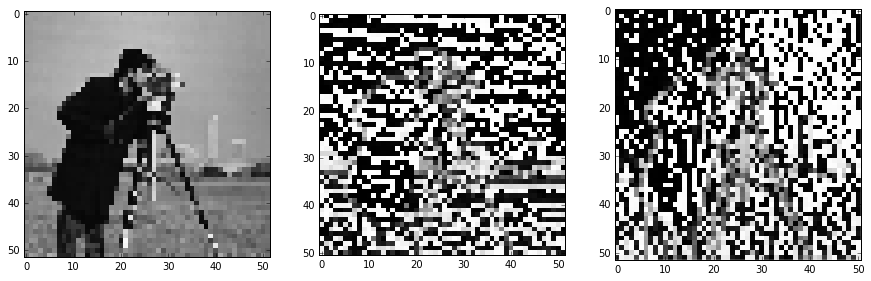

In [29]:
imshow_all(pixelated, vertical_gradient, horizontal_gradient)

That's obviously not what we were hoping for: It all looks like noise. What's wrong here?

In addition to the more obvious issues above, this operation has two additional issues, which can be seen below:

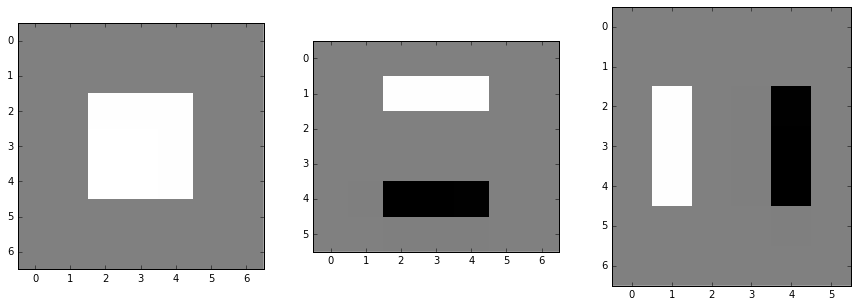

In [34]:
vertical_gradient = bright_square[1:, :] - bright_square[:-1, :]
horizontal_gradient = bright_square[:, 1:] - bright_square[:, :-1]
imshow_all(bright_square, vertical_gradient, horizontal_gradient)

In [35]:
print(bright_square.shape, horizontal_gradient.shape)

(7, 7) (7, 6)


In [36]:
np.convolve?

Note here that:
1. The shape of the image isn't preserved
2. The operation skews edges to one corner of the image.

This difference operation gives the gradient *in-between* pixels, but we typically want the gradient at the same pixels as the original image.

---

## <span style="color:cornflowerblue">Exercise:</span>

Create a simple difference filter to **find the horizontal or vertical edges** of an image. Try to ensure that the filtering operation doesn't shift the edge position preferentially. (Don't use slicing to produce the difference image; use convolution.)

This should get you started:

In [ ]:
# Replace the kernels below with your difference filter
# `ones` is used just for demonstration and your kernel 
# should be larger than (1, 1)
horizontal_edge_kernel = np.ones((1, 1))
vertical_edge_kernel = np.ones((1, 1))

# As discussed earlier, you may want to replace pixelated
# with a different image.
image = pixelated
# NOTE: A **vertical** gradient has a strong response at 
# **horizontal** edges and vice versa.
vertical_gradient = convolve(image, horizontal_edge_kernel)
horizontal_gradient = convolve(image, vertical_edge_kernel)
imshow_all(horizontal_gradient, vertical_gradient)

---

### Sobel edge filter

The Sobel filter, the most commonly used edge filter, should look pretty similar to what you developed above. Take a look at the vertical and horizontal components of the Sobel kernel to see how they differ from your earlier implementation:

* http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_v
* http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_h

The standard Sobel filter gives the gradient magnitude. This is similar to what we saw above, except that horizontal and vertical components are combined such that the direction of the gradient is ignored.

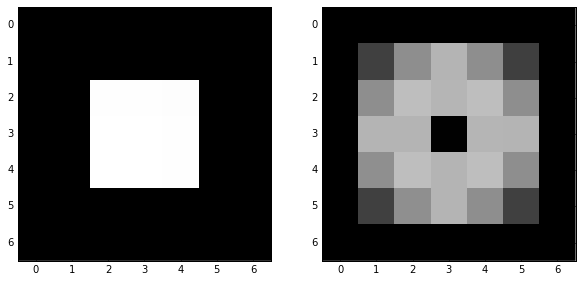

In [37]:
imshow_all(bright_square, filters.sobel(bright_square))

Notice that the size of the output matches the input, and the edges aren't preferentially shifted to a corner of the image. Furthermore, the weights used in the Sobel filter produce diagonal edges with reponses that are comparable to horizontal or vertical edges.

Like any derivative, noise can have a strong impact on the result:

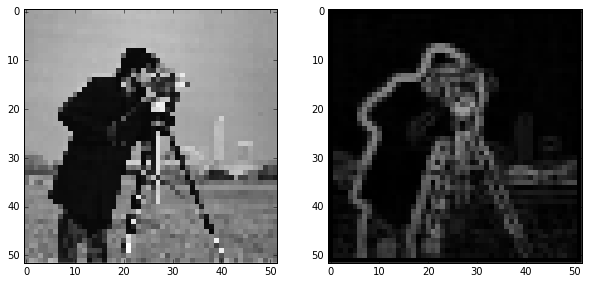

In [38]:
pixelated_gradient = filters.sobel(pixelated)
imshow_all(pixelated, pixelated_gradient)

Smoothing is often used as a preprocessing step in preparation for feature detection and image-enhancement operations because sharp features can distort results.

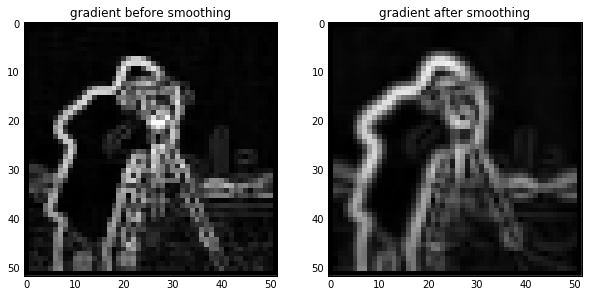

In [39]:
gradient = filters.sobel(smooth)
titles = ['gradient before smoothing', 'gradient after smoothing']
# Scale smoothed gradient up so they're of comparable brightness.
imshow_all(pixelated_gradient, gradient*1.8, titles=titles)

Notice how the edges look more continuous in the smoothed image.

---

## Denoising filters

This is a bit arbitrary, but here, we distinguish smoothing filters from denoising filters. We'll label denoising filters as those that are edge preserving.

As you can see from our earlier examples, mean and Gaussian filters smooth an image rather uniformly, including the edges of objects in an image. When denoising, however, you typically want to preserve features and just remove noise. The distinction between noise and features can, of course, be highly situation-dependent and subjective.

### Median Filter

The median filter is the classic edge-preserving filter. As the name implies, this filter takes a set of pixels (i.e. the pixels within a kernel or "structuring element") and returns the median value within that neighborhood. Because regions near a sharp edge will have many dark values and many light values (but few values in between) the median at an edge will most likely be either light or dark, rather than some value in between. In that way, we don't end up with edges that are smoothed.

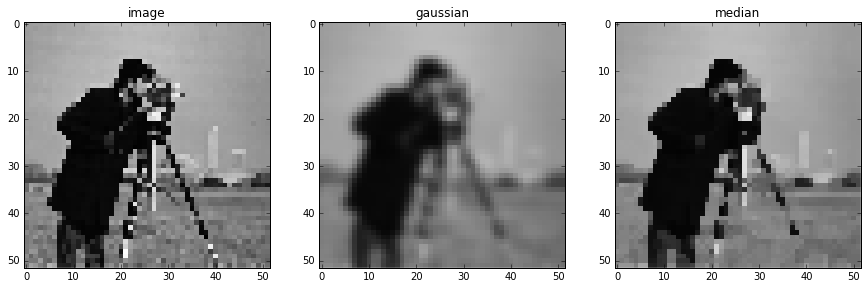

In [40]:
from skimage.morphology import disk
selem = disk(1)  # "selem" is often the name used for "structuring element"
median = filters.rank.median(pixelated, selem)
titles = ['image', 'gaussian', 'median']
imshow_all(pixelated, smooth, median, titles=titles)

This difference is more noticeable with a more detailed image.

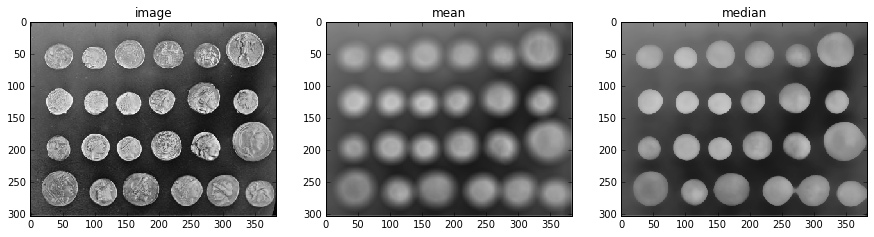

In [41]:
selem = disk(10)
coins = data.coins()
mean_coin = filters.rank.mean(coins, selem)
median_coin = filters.rank.median(coins, selem)
titles = ['image', 'mean', 'median']
imshow_all(coins, mean_coin, median_coin, titles=titles)

Notice how the edges of coins are preserved after using the median filter.

## Further reading

`scikit-image` also provides more sophisticated denoising filters:

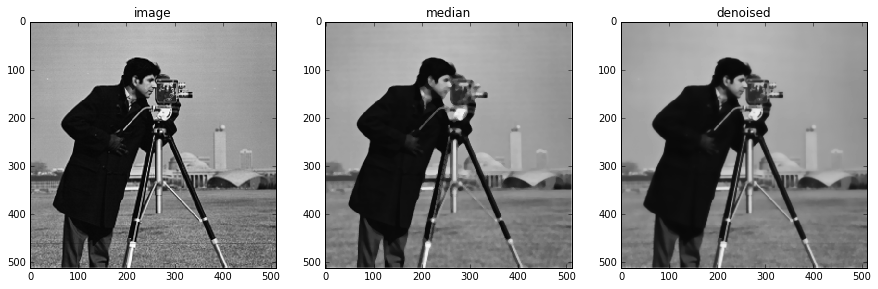

In [43]:
from skimage.restoration import denoise_tv_bregman
denoised = denoise_tv_bregman(image, 4)
d = disk(4)
median = filters.rank.median(image, d)
titles = ['image', 'median', 'denoised']
imshow_all(image, median, denoised, titles=titles)

* [Denoising examples](http://scikit-image.org/docs/dev/auto_examples/plot_denoise.html)
* [Rank filters example](http://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html)

---

<div style="height: 400px;"></div>

In [ ]:
%reload_ext load_style
%load_style ../themes/tutorial.css